# 02506 Week 10, CNN for image segmentation
*Mini UNet*

This is a notebook for exercise on segmentation using UNet-like architecture.

To enable GPU change the settings under Edit -> Notebook Settings!

Tasks (check also tasks in course note):
1.   Get familiar with the code. Run all cells and make sure you have an idea of what's happening.
2.   The segmentation network in this notebook is inspired by UNet, but smaller. Based on the code, draw architecture of this network. That is, produce an image similar to [this](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png), but with dimensions as used in the exercise.
3.   The network is designed to take image patches of size 128-by-128. But being fully convolutional, it can also take images of other sizes, as long as donwscaling, upscaling and concatination may be preformed. 
4.   Chack the weights of the trained network. You  can consider visualizing the kernels. 
5.   Try visualizing netwoork layers (neuron values), when passing one image through the network. 
6.    Make an attempt of segmenting a large image.



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import PIL.Image

In [19]:
# Retreive and extract data set, do this only once.
# (To see the file in the directory (side panel), reload the page.)
import os

datadir = 'glands/'  # path to the directory containing data
if not os.path.isdir('glands'):
    !wget -q http://www2.imm.dtu.dk/courses/02506/data/week10/glands.zip
    import shutil
    shutil.unpack_archive('glands.zip', 'glands')

In [20]:
# Make dataset class.
class GlandData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, margin_size=20):
        self.images = []
        self.labels = []
        for idx in range(nr_im):
            im = np.array(PIL.Image.open(f'{data_dir}{idx:03d}.png'))
            im = im.transpose(2, 0, 1)/255
            self.images.append(torch.tensor(im, dtype=torch.float32))
            label_im = np.array(PIL.Image.open(f'{data_dir}{idx:03d}_anno.png'))
            label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
            self.labels.append(torch.tensor(label_im, dtype=torch.int64))

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.images)

In [21]:
# Make training and validation set.
# (This involves loading images and may take some seconds.)

glandTrainData = GlandData(datadir + 'train/train_', 750)
glandTestData = GlandData(datadir + 'test/test_', 240)


Nr. training images: 750
Nr. testing images: 240


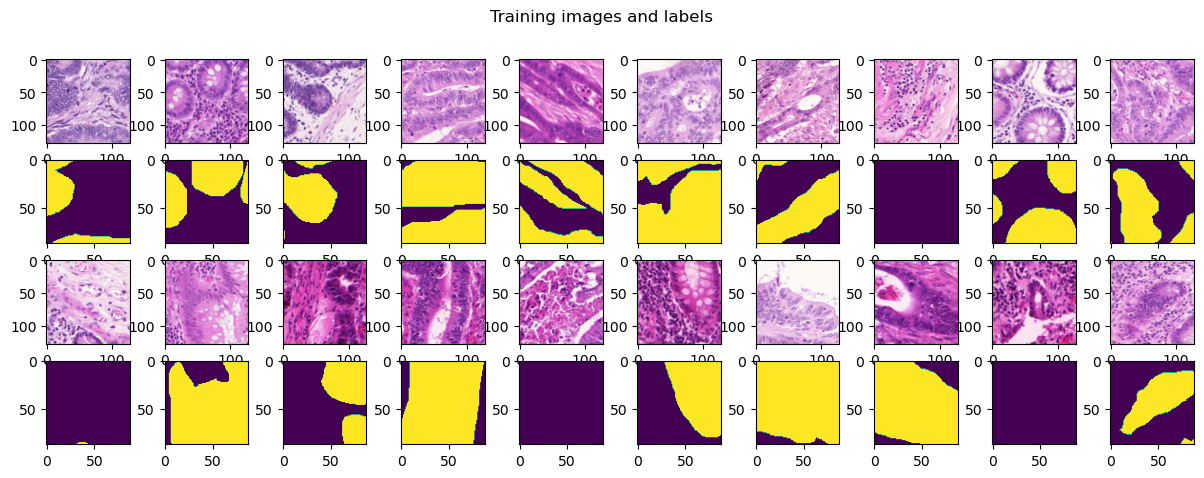

In [22]:
#%% Check if implementation of dataset works as expected.

print(f'Nr. training images: {len(glandTrainData)}')
print(f'Nr. testing images: {len(glandTestData)}')

N = 10
fig, ax = plt.subplots(4, N, figsize=(15,5))
for k in range(2):

    rand_idx = np.random.choice(len(glandTrainData), size=N, replace=False)    
    for n, idx in enumerate(rand_idx):
        
        im, lab = glandTrainData[idx]    
        ax[0+2*k, n].imshow(im.permute(1,2,0))
        ax[1+2*k, n].imshow(lab)
fig.suptitle('Training images and labels')
plt.show()

In [7]:
#%% Make model class.
class UNet128(torch.nn.Module):
    """Takes in patches of 128^2 RGB, returns 88^2"""
    
    def __init__(self, out_channels=2):
        super().__init__()

        # Learnable
        self.conv1A = torch.nn.Conv2d(3, 8, 3)  
        self.conv1B = torch.nn.Conv2d(8, 8, 3)  
        self.conv2A = torch.nn.Conv2d(8, 16, 3)  
        self.conv2B = torch.nn.Conv2d(16, 16, 3)  
        self.conv3A = torch.nn.Conv2d(16, 32, 3)  
        self.conv3B = torch.nn.Conv2d(32, 32, 3)  
        self.conv4A = torch.nn.Conv2d(32, 16, 3)  
        self.conv4B = torch.nn.Conv2d(16, 16, 3)  
        self.conv5A = torch.nn.Conv2d(16, 8, 3)  
        self.conv5B = torch.nn.Conv2d(8, 8, 3)  
        self.convfinal = torch.nn.Conv2d(8, out_channels, 1)         
        self.convtrans34 = torch.nn.ConvTranspose2d(32, 16, 2, stride=2) 
        self.convtrans45 = torch.nn.ConvTranspose2d(16, 8, 2, stride=2)
        
        # Convenience
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)        
       
    def forward(self, x):
 
        # Down, keeping layer outputs we'll need later.
        l1 = self.relu(self.conv1B(self.relu(self.conv1A(x))))
        l2 = self.relu(self.conv2B(self.relu(self.conv2A(self.pool(l1)))))
        out = self.relu(self.conv3B(self.relu(self.conv3A(self.pool(l2))))) 
        
        # Up, now we overwritte out in each step.
        out = torch.cat([self.convtrans34(out), l2[:,:,4:-4,4:-4]], dim=1)
        out = self.relu(self.conv4B(self.relu(self.conv4A(out))))
        out = torch.cat([self.convtrans45(out), l1[:,:,16:-16,16:-16]], dim=1)      
        out = self.relu(self.conv5B(self.relu(self.conv5A(out))))
   
         # Finishing
        out = self.convfinal(out)
  
        return out

In [8]:
# Figure out whether to use cpu or cuda.

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using mps')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using mps


In [9]:
# Initiate the model, dataloaders and optimizer.

lr = 0.0001
nr_epochs = 50

#  Loaders for training and testing set
trainloader = torch.utils.data.DataLoader(glandTrainData,
                                          batch_size=10,
                                          shuffle=True,
                                          drop_last=True)
testloader = torch.utils.data.DataLoader(glandTestData,
                                          batch_size=20)
model = UNet128().to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

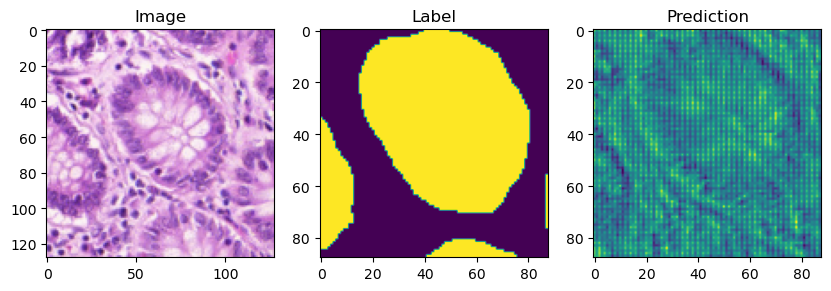

In [10]:
# Prepare for book-keeping during training.
epoch_losses = []
batch_losses = []
test_losses = []

# Pick an image to show how predictitons change.
i = 50
im, lb = glandTrainData[i]
with torch.no_grad():
  lgt = model(im.unsqueeze(0).to(device))
  prob = torch.nn.functional.softmax(lgt, dim=1)

fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].imshow(im.permute(1,2,0))
ax[0].set_title('Image')
ax[1].imshow(lb)
ax[1].set_title('Label')
ax[2].imshow(prob[0,1].cpu().detach())
ax[2].set_title('Prediction')
plt.show()

Epoch 0/50, loss 0.6954189666112264
Epoch 1/50, loss 0.6945160921414694
Epoch 2/50, loss 0.6937152560551961
Epoch 3/50, loss 0.6926026352246603
Epoch 4/50, loss 0.6912307802836101
Epoch 5/50, loss 0.6881274763743083
Epoch 6/50, loss 0.6743130946159362
Epoch 7/50, loss 0.657605414390564
Epoch 8/50, loss 0.6454579957326253
Epoch 9/50, loss 0.6387257504463196


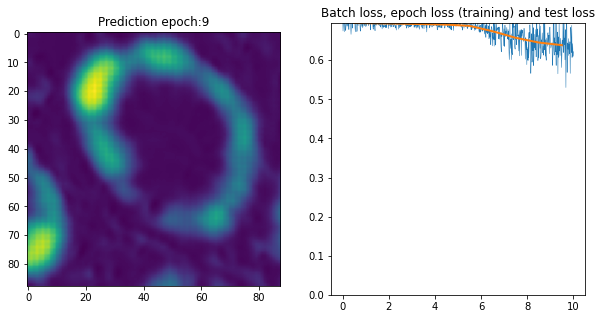

Epoch 10/50, loss 0.6270763174692789
Epoch 11/50, loss 0.6151581438382466
Epoch 12/50, loss 0.6059020153681437
Epoch 13/50, loss 0.5996888661384583
Epoch 14/50, loss 0.594406039317449
Epoch 15/50, loss 0.5907138379414877
Epoch 16/50, loss 0.5822214897473653
Epoch 17/50, loss 0.5770996495087941
Epoch 18/50, loss 0.5850704292456309
Epoch 19/50, loss 0.5708407771587372


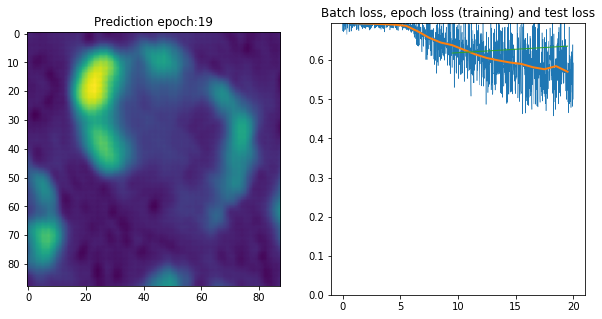

Epoch 20/50, loss 0.5744914515813192
Epoch 21/50, loss 0.569301544825236
Epoch 22/50, loss 0.5612284608681997
Epoch 23/50, loss 0.556139143705368
Epoch 24/50, loss 0.5587178711096445
Epoch 25/50, loss 0.5526851149400075
Epoch 26/50, loss 0.5483785895506541
Epoch 27/50, loss 0.5394160143534342
Epoch 28/50, loss 0.5397929728031159
Epoch 29/50, loss 0.5363106195131938


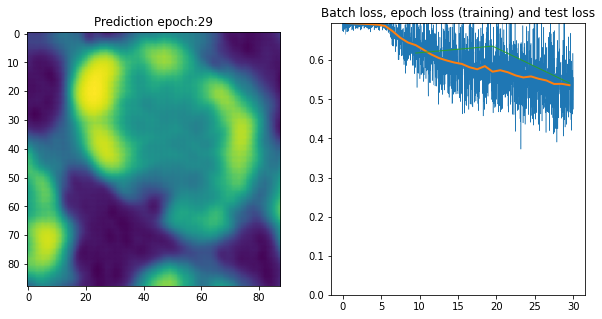

Epoch 30/50, loss 0.5348740903536479
Epoch 31/50, loss 0.5277055625120799
Epoch 32/50, loss 0.5352599585056305
Epoch 33/50, loss 0.535463438431422
Epoch 34/50, loss 0.5231981535752614
Epoch 35/50, loss 0.5250209967295328
Epoch 36/50, loss 0.5239330768585205
Epoch 37/50, loss 0.5253230094909668
Epoch 38/50, loss 0.5361110428969066
Epoch 39/50, loss 0.5230298531055451


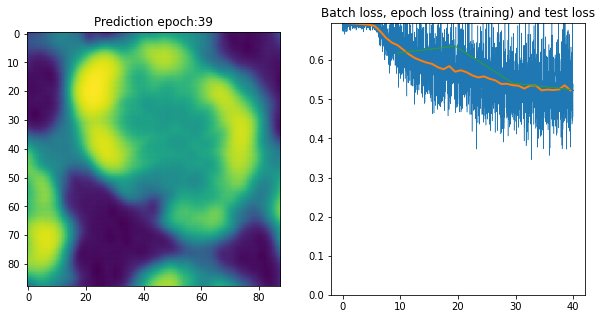

Epoch 40/50, loss 0.5153110539913177
Epoch 41/50, loss 0.5194105752309164
Epoch 42/50, loss 0.5154727705319723
Epoch 43/50, loss 0.5164239645004273
Epoch 44/50, loss 0.5224966541926066
Epoch 45/50, loss 0.51252241452535
Epoch 46/50, loss 0.5106819081306457
Epoch 47/50, loss 0.5144315751393637
Epoch 48/50, loss 0.5117110208670298
Epoch 49/50, loss 0.5119325097401937


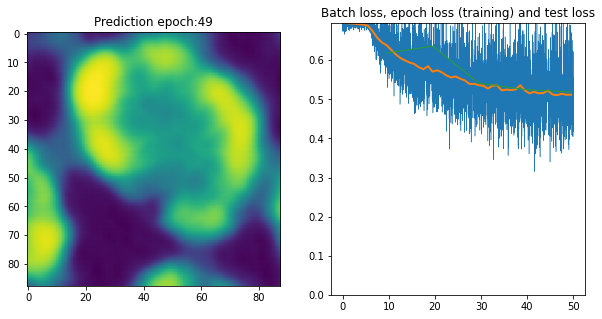

In [ ]:
# Train.
for epoch in range(nr_epochs):
    print(f'Epoch {epoch}/{nr_epochs}', end='')

    epoch_loss = 0.0
    for batch in trainloader:
        
        image_batch, label_batch = batch  # unpack the data
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        logits_batch = model(image_batch)
        optimizer.zero_grad()
        loss = loss_function(logits_batch, label_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())

    epoch_losses.append(epoch_loss / len(trainloader))
    print(f', loss {epoch_losses[-1]}')

    if epoch % 10 == 9: 
        #  Book-keeping and visualizing every tenth iterations
        with torch.no_grad():
            lgt = model(im.unsqueeze(0).to(device))
            test_loss = 0
            for batch in testloader:
                image_batch, label_batch = batch  # unpack the data
                image_batch = image_batch.to(device)
                label_batch = label_batch.to(device)
                logits_batch = model(image_batch)
                loss = loss_function(logits_batch, label_batch)
                test_loss += loss.item()
            test_losses.append(test_loss / len(testloader))
                
        prob = torch.nn.functional.softmax(lgt, dim=1)
    
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(prob[0,1].cpu().detach())
        ax[0].set_title(f'Prediction, epoch:{len(epoch_losses) - 1}')
    
        ax[1].plot(np.linspace(0, len(epoch_losses), len(batch_losses)), 
                     batch_losses, lw=0.5)
        ax[1].plot(np.arange(len(epoch_losses)) + 0.5, epoch_losses, lw=2)
        ax[1].plot(np.linspace(9.5, len(epoch_losses)-0.5, len(test_losses)), 
                     test_losses, lw=1)
        ax[1].set_title('Batch loss, epoch loss (training) and test loss')
        ax[1].set_ylim(0, 1.1*max(epoch_losses + test_losses))
        plt.show()

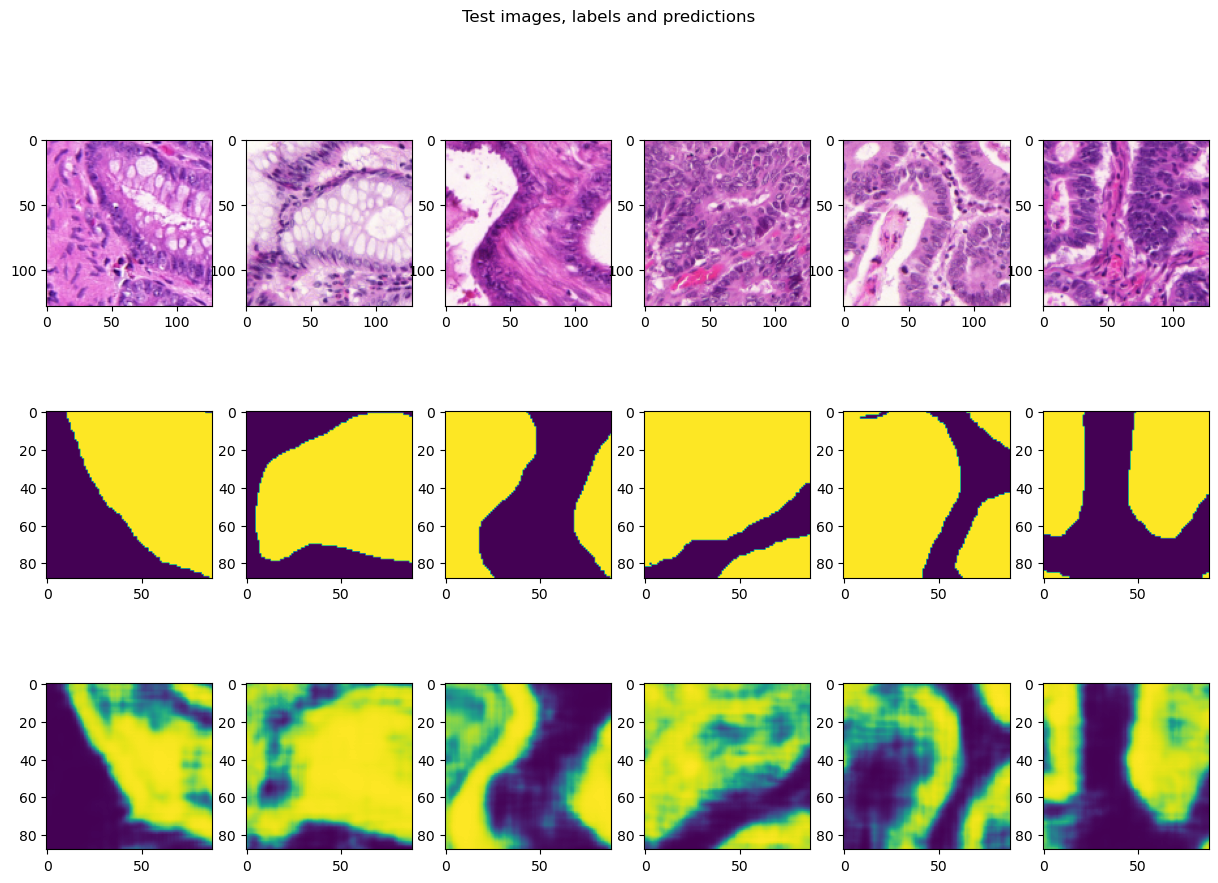

In [13]:
#%%  Show predictions for a few images from the test set.

idxs = [19, 50, 61, 100, 151, 230]
fig, ax = plt.subplots(3, len(idxs), figsize=(15, 10))

for n, idx in enumerate(idxs):
    im_val, lb_val = glandTestData[idx]
    with torch.no_grad():
        lgt_val = model(im_val.unsqueeze(0).to(device))
    prob_val = torch.nn.functional.softmax(lgt_val, dim=1)
    
    ax[0, n].imshow(im_val.permute(1,2,0))
    ax[1, n].imshow(lb_val)
    ax[2, n].imshow(prob_val[0,1].cpu().detach())
fig.suptitle('Test images, labels and predictions')
plt.show()

In [12]:
#%%  Instead of training, you can also load the saved model parameters.
!wget 'http://www2.imm.dtu.dk/courses/02506/data/week10/checkpoint_500.pth' -q
model.load_state_dict(torch.load('checkpoint_500.pth')['model_statedict'])
optimizer.load_state_dict(torch.load('checkpoint_500.pth')['optimizer_statedict'])